In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s gdrive/'Team Drives'/'Data Mining Team'/ gdata

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls gdata/

'Preprocessing link.gdoc'   yelpDataset.ipynb	      yelpHotelData.db
'Project proposal.gdoc'     yelpDataset_kunj.ipynb    YelpNeha.ipynb
'Untitled document.gdoc'    yelpDataset_shrey.ipynb


In [2]:
!pip install contractions

In [0]:
import numpy as np
import pandas as pd
import nltk
import spacy
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re, string, unicodedata
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

%matplotlib inline

In [0]:
import sqlite3
import pandas as pd
connection = sqlite3.connect('gdata/yelpHotelData.db')
x1 = connection.execute("select * FROM review")
#x1 = pd.DataFrame(x1)
data = pd.read_sql("select * FROM review", connection)

In [6]:
data.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,hotelID
0,6/8/2011,MyNjnxzZVTPq,IFTr6_6NI4CgCVavIL9k5g,Let me begin by saying that there are two kind...,5,18,11,28,N,tQfLGoolUMu2J0igcWcoZg
1,8/30/2011,BdD7fsPqHQL73hwENEDT-Q,c_-hF15XgNhlyy_TqzmdaA,The only place inside the Loop that you can st...,3,0,3,4,N,tQfLGoolUMu2J0igcWcoZg
2,6/26/2009,BfhqiyfC,CiwZ6S5ZizAFL5gypf8tLA,I have walked by the Tokyo Hotel countless tim...,5,12,14,23,N,tQfLGoolUMu2J0igcWcoZg
3,9/16/2010,Ol,nf3q2h-kSQoZK2jBY92FOg,"If you are considering staying here, watch thi...",1,8,2,6,N,tQfLGoolUMu2J0igcWcoZg
4,2/5/2010,i4HIAcNTjabdpG1K4F5Q2g,Sb3DJGdZ4Rq__CqxPbae-g,"This place is disgusting, absolutely horrible,...",3,11,4,9,N,tQfLGoolUMu2J0igcWcoZg


In [0]:
description = []
Class = []

data = x1.fetchmany(688329)

for x in data:
  description.append(x[3])
  Class.append(x[8])
trainData = {'Class' : Class, 'Description' : description}
df_X = pd.DataFrame(trainData)

In [22]:
df_X['Class'].value_counts()
#df_X


Series([], Name: Class, dtype: int64)

In [23]:
#Convert NR->N , YR->Y
df_X.loc[df_X['Class'] == "NR", 'Class'] = "N"
df_X.loc[df_X['Class'] == "YR", 'Class'] = "Y"
df_X['Class'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Series([], Name: Class, dtype: int64)

In [0]:
import time
import pickle
pd.set_option('display.max_colwidth', 200)

In [25]:
df_X['Class'].value_counts(normalize = True)

Series([], Name: Class, dtype: float64)

In [0]:
'''def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

df_X['clean_desc'] = denoise_text(df_X['Description'])
print(df_X)'''

In [0]:
# remove URL's from train and test
 df_X['clean_desc']= df_X['Description'].apply(lambda x: re.sub(r'http\S+', '', x))


In [0]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~.,'

df_X['clean_desc'] = df_X['clean_desc'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

In [28]:
# convert text to lowercase
df_X['clean_desc'] = df_X['clean_desc'].str.lower()

AttributeError: ignored

In [29]:
# remove numbers
df_X['clean_desc'] = df_X['clean_desc'].str.replace("[0-9]", " ")

AttributeError: ignored

In [0]:
# remove whitespaces
df_X['clean_desc'] = df_X['clean_desc'].apply(lambda x:' '.join(x.split()))

In [0]:
# import spaCy's language model
nlp = spacy.load('en', disable=['parser', 'ner'])


In [0]:
# tokenization using spaCy
def tokenization(x):
    desc_tokens = []
    for i in tqdm(x):
        i = nlp(i)
        temp = []
        for j in i:
            temp.append(j.text)
        desc_tokens.append(temp)
    
    return desc_tokens

In [31]:
#Tokenization for Train data
df_X['clean_desc'] = tokenization(df_X['clean_desc'])

0it [00:00, ?it/s]


In [0]:
#function to remove stopwords
def remove_stopwords(desc):
    s = []
    for r in tqdm(desc):
        s_2 = []
        for token in r:
            if nlp.vocab[token].is_stop == True:
                continue
            else:
                s_2.append(token)
        s.append(" ".join(s_2))    
        
    return s

In [0]:
df_X['clean_desc'] = remove_stopwords(df_X['clean_desc'])

100%|██████████| 10000/10000 [00:01<00:00, 7954.03it/s]


In [0]:
# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
             s = [token.lemma_ for token in nlp(i)]
             output.append(' '.join(s))
    return output

In [0]:
df_X['clean_desc'] = lemmatization(df_X['clean_desc'])

In [0]:
df_X.sample(10)

,Class,Description,clean_desc
4075,N,"This is a convention galore hotel. It's impersonal, but for $65/night with a view, I'm not complaining! I got lucky with the view. The spacious room was probably bigger than a studio rental in ...",convention galore hotel impersonal night view ' m complain lucky view spacious room probably big studio rental sf king size bed comfy actually end sleep day hyatt conveniently locate near el train...
101,N,"Location is excellent. Right near the Magnificent Mile and Pizzeria Uno and Pizzeria Due. There's even a Starbucks and a Trader Joe's across the street. Rooms are small. Beds are small, more li...",location excellent right near magnificent mile pizzeria uno pizzeria 's starbucks trader joe 's street room small bed small like queen bathroom small smell kinda weird wall thin breakfast pretty a...
8250,YR,i could have sworn i wrote a review of sonny bryan's.. although i prefer mike anderson's.. sonny bryan's is always pretty good.. the brisket is the star here.. but the ribs are pretty damn amazing...,swear write review sonny bryan 's prefer mike anderson 's sonny bryan 's pretty good brisket star rib pretty damn amazing place good bbq sauce good bbq restaurant
2369,N,"Alright, friends. I'm going to be as straightforward as possible. This place is a dump. It's just gross. I'm tempted to leave it at this, but I feel obligated to let you know why this place is...",alright friend ' m straightforward possible place dump gross ' m tempt leave feel obligate let know place avoidatallcost establishment premise stay hilton work trip bf week ago firm pay room tag y...
8505,NR,"Cute atmosphere, it's a decent place for lunch with friends. Everything was surprisingly fresh and tasty. We just got a few rolls to share- but I agree with other comments that their ""spicy"" is la...",cute atmosphere 's decent place lunch friend surprisingly fresh tasty roll share agree comment spicy lack downside bill large lunch friend expect consider sushi area 's forever check like staff ov...
4375,N,I lived in Chicago for a few years between high school and college (sometime shortly after Gutenberg had printed his first Bible). I was too young and too poor to enjoy many of the places I would...,live chicago year high school college shortly gutenberg print bible young poor enjoy place like register huge scientific meeting chicago choose palm house hotel explain choice colleague tell elega...
4177,N,"First of all, I've been in the hotel for an event and I thought it was well run and the staff was very nice. This past weekend my friends stayed here while visiting for New Year's Eve. I thought...",' ve hotel event think run staff nice past weekend friend stay visit new year 's eve think room little small decent staff fine hotel huge nye party guest wear wristband fine visitor allow purchase...
7184,YR,"I love you Fran's. Your dark chocolate salted caramels are the best. thing. ever. I've even gotten my mother in Alabama hooked on them. Ok, so you're not cheap... at all, but you use high quality ...",love fran 's dark chocolate salt caramel good thing ' ve mother alabama hook ok cheap use high quality ingredient hand worth
9855,NR,"While small, NV was a pretty great spot for another awesome Elite Event. The cupcakes looked amazing but I did not partake (not a sweets fan). However, I could not get enough of the special drinks...",small nv pretty great spot awesome elite event cupcake look amazing partake sweet fan special drink evening festive yummy entertainment evening speak poetry read white elephant gift exchange disap...
3188,N,"I have stayed at the W (Lakeshore Drive) a handful of times, and I have never been disappointed. The staff is very polite, the rooms are well appointed, and the scene/atmosphere is very young and ...",stay w lakeshore drive handful time disappointed staff polite room appoint sceneatmosphere young trendy favorite aspect hotel small thing expect season ritz carlton 's peninsula chicago w change e...


In [0]:
# remove anything smaller then length 4 in training set
df_X['clean_desc'] = df_X['clean_desc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [0]:
df_X.sample(10)

,Class,Description,clean_desc
8728,NR,Fabulous little shop with great workers. There are some really unique items found here and the people working there are very helpful and educated. They were able to tell me all about the products ...,fabulous little shop great worker unique item find people work helpful educate able tell product store region greece mastiha find great place spend time
6940,NR,"I love this is GYM, it is the BEST!Talk about a gym this place is the standard for what all gyms should aspire to. The Equipment: They have it all and they are generally clean. Even when it is pac...",love gym besttalk gym place standard gym aspire equipment generally clean pack treadmill cardio machine use class line leandro brazilian butt lift tummy tuck corey hill daryle gain cycling class f...
6877,NR,"If you love Carrot Cake as much as I do, you will understand this review: When I have a sweet craving I just need the right fix. The first time I went here I bought a slice of the Red Velvet Cake,...",love carrot cake understand review sweet craving need right fix time buy slice red velvet cake carrot cake special second time carrot cake worker sell time carrot cake time ask worker come carrot ...
5086,Y,"I was there for a birthday party and had a wonderful time. Although the place has been open for a number of years, is still well maintained. Great Crowd!",birthday party wonderful time place open number year maintain great crowd
8573,YR,"Been here a few times, and everytime was a delite. They are pretty generous with their portions and its not too pricy. They are slammed during prime lunch/dinner hours so it may take a minute when...",time everytime delite pretty generous portion pricy slam prime lunchdinner hour minute ordering peak hour food taste great service right
1717,N,"This is a pretty good hotel for the Loop, but I think I came at the wrong time. It was way too crowded, the elevators took FOREVER, and the gym was packed to the gills. It's understandable that th...",pretty good hotel loop think come wrong time way crowd elevator forever gym pack gill understandable gym lobby busy hotel elevator problem real hassle frustrating wait maybe minute elevator finall...
5728,N,First of all it cost $399 to book a single room for 1 night which is an outrageous price. It was a standard room that mimics any of the major chain hotels. After staying there I have been trying t...,cost book single room night outrageous price standard room mimic major chain hotel stay try electronic invoice avail time run assuring receive invoice email
4585,N,"So, I really wanted to love this place and my initial impression was fantastic. The lobby is beautiful & luxurious and I couldn't wait to check-in and relax in our room. And here's where it all we...",want love place initial impression fantastic lobby beautiful luxurious n't wait checkin relax room downhill desk clerk little snippy key send way find room double bed reserve think desk clerk thin...
3711,N,I visited the Drake for tea time and dinner before the Symphony. The hotel has a lot of history and it was a pleasure to walk around and experience the feeling of the place. There were many thin...,visit drake tea time dinner symphony hotel lot history pleasure walk experience feel place thing day tea room completely book seat quickly table near fountain harpist play tea serve find sandwich ...
6254,NR,"What's to say about Denny's? It just is! Standard American diner fare, served 24 hours a day. Here in suburbia it's a resource for us night owls who stay up late and need a food fix at weird ho...",denny standard american diner fare serve hour day suburbia resource night owl stay late need food fix weird hour grit breakfast common kansa city location near place metro check website near


In [0]:
# # import tensorflow_hub as hub
# import tensorflow as tf

In [0]:
# elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [0]:
# def elmo_vectors(x):
#   embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

#   with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(tf.tables_initializer())
#     # return average of ELMo features
#     return sess.run(tf.reduce_mean(embeddings,1))

In [0]:
# list_train = [df_X[i:i+100] for i in range(0,df_X.shape[0],100)]

In [0]:
# # Extract ELMo embeddings
# elmo_train = [elmo_vectors(x['clean_desc']) for x in list_train]

UnknownError: ignored

In [0]:
# import re

# clean_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
# clean_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
# # function to clean text data
# def clean_desc(desc):
#     desc = [clean_1.sub("", line.lower()) for line in desc]
#     desc = [clean_2.sub(" ", line) for line in desc]
#     return desc

In [0]:
# df_X['Description'] = clean_desc(df_X['Description'])

In [0]:
# from nltk import FreqDist

In [0]:
# # function to plot top n most frequent words
# def freq_words(x, terms = 30):
#   all_words = ' '.join([text for text in x])
#   all_words = all_words.split()
  
#   fdist = FreqDist(all_words)
#   words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
#   # selecting top n most frequent words
#   d = words_df.nlargest(columns="count", n = terms) 
#   plt.figure(figsize=(20,5))
#   ax = sns.barplot(data=d, x= "word", y = "count")
#   ax.set(ylabel = 'Count')
#   plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


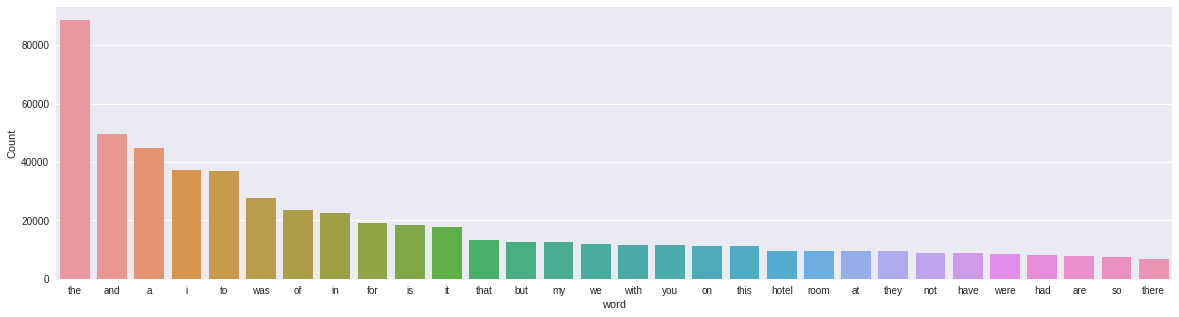

In [0]:
# freq_words(df_X['Description'])

In [0]:
nlp = spacy.load('en_core_web_sm')

In [0]:
# # tokenization using spaCy
# def tokenization(x):
#     desc_tokens = []
#     for i in tqdm(x):
#         i = nlp(i)
#         temp = []
#         for j in i:
#             temp.append(j.text)
#         desc_tokens.append(temp)
    
#     return desc_tokens

In [0]:
# #Tokenization for Train data
# df_X['tokenized_desc'] = tokenization(df_X['Description'])


100%|██████████| 10000/10000 [10:37<00:00, 17.12it/s]


In [0]:
# function to remove stopwords
def remove_stopwords(desc):
    s = []
    for r in tqdm(desc):
        s_2 = []
        for token in r:
            if nlp.vocab[token].is_stop == True:
                continue
            else:
                s_2.append(token)
        s.append(" ".join(s_2))    
        
    return s

In [0]:
df_X['Desc_cleaned'] = remove_stopwords(df_X['tokenized_desc'])

100%|██████████| 10000/10000 [00:02<00:00, 4384.96it/s]


In [0]:
# remove anything smaller then length 4 in training set
df_X['Desc_cleaned'] = df_X['Desc_cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


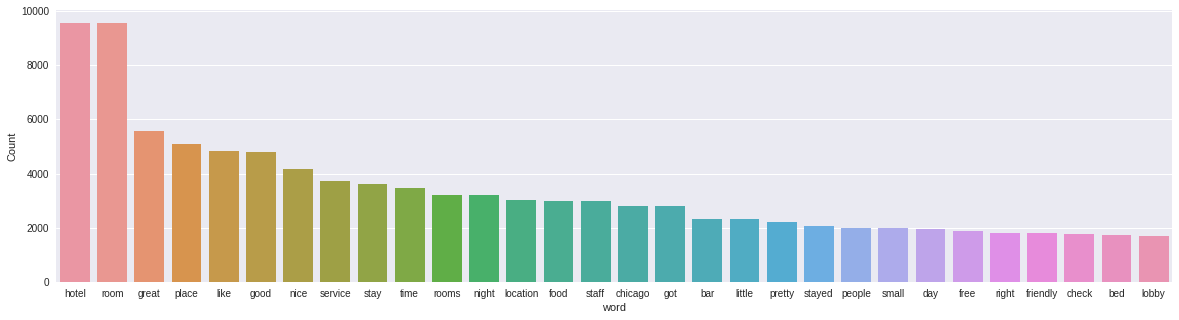

In [0]:
freq_words(df_X['Desc_cleaned'])

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# build TF-IDF features for train data
cv = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.4, ngram_range=(1,2),
                        sublinear_tf=True,)
cv_train = cv.fit_transform(df_X['Desc_cleaned'])

In [0]:
cv_train

<10000x21644 sparse matrix of type '<class 'numpy.float64'>'
	with 668903 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cv_train,df_X['Class'], test_size=0.3, random_state=42)

In [0]:
X_train.shape

(7000, 21644)

In [0]:
X_test.shape

(3000, 21644)

In [0]:
y_train.shape

(7000,)

In [0]:
y_test.shape

(3000,)

In [0]:
from sklearn import svm

In [0]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')

clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
from sklearn import metrics
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.82      0.98      0.89      1551
          NR       0.62      0.87      0.73       746
           Y       0.00      0.00      0.00       240
          YR       0.66      0.18      0.28       463

   micro avg       0.75      0.75      0.75      3000
   macro avg       0.53      0.50      0.47      3000
weighted avg       0.68      0.75      0.68      3000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.metrics import roc_auc_score

ValueError: ignored

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [0]:
# clfrNB = MultinomialNB(alpha = 0.1)
# clfrNB.fit(X_train, y_train)
# preds = clfrNB.predict(X_test)
# score = roc_auc_score(y_test, preds)
# print(score)